# Ensembles

En esta notebook vamos a cargar el modelo que mejor anduvo en la CV


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
import random
import torch

random_seed = 10101119

torch.manual_seed(2*random_seed)
np.random.seed(3*random_seed)
tf.random.set_random_seed(random_seed+1)
random.seed(random_seed/2 + 1)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df_dev = pd.read_table("../../../data/en/dev_en.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/en/train_en.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_test = pd.read_table("../../../data/en/reference_en.tsv", header=None, 
                        names=["text", "HS", "TR", "AG"], quoting=csv.QUOTE_NONE)


X_train, y_train = df_train["text"], df_train["HS"]
X_dev, y_dev = df_dev["text"], df_dev["HS"]
X_test, y_test = df_test["text"], df_test["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))
print("Instancias de test: {}".format(len(df_test)))


Instancias de entrenamiento: 9000
Instancias de desarrollo: 1000
Instancias de test: 2971


In [2]:
from hate.nn.preprocessing import Tokenizer

tokenizer = Tokenizer()

tokens_train = [tokenizer.tokenize(t) for t in X_train]

Using TensorFlow backend.


Hagamos tokenize sobre el texto

(array([ 366., 1747., 1987., 2059., 1170.,  584.,  601.,  373.,   95.,
          18.]),
 array([ 0.,  7., 14., 21., 28., 35., 42., 49., 56., 63., 70.]),
 <a list of 10 Patch objects>)

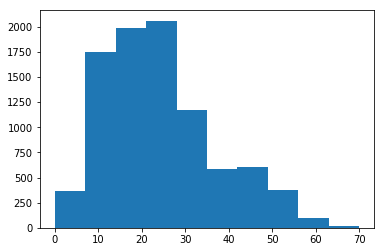

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])


In [4]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/en/", batch_size=32)

2019-02-21 10:19:00,409 INFO: char embedding size: 4939
2019-02-21 10:19:01,187 INFO: word embedding size: 167642
2019-02-21 10:19:10,438 INFO: Model(
  (token_embedder): ConvTokenEmbedder(
    (word_emb_layer): EmbeddingLayer(
      (embedding): Embedding(167642, 100, padding_idx=3)
    )
    (char_emb_layer): EmbeddingLayer(
      (embedding): Embedding(4939, 50, padding_idx=4936)
    )
    (convolutions): ModuleList(
      (0): Conv1d(50, 32, kernel_size=(1,), stride=(1,))
      (1): Conv1d(50, 32, kernel_size=(2,), stride=(1,))
      (2): Conv1d(50, 64, kernel_size=(3,), stride=(1,))
      (3): Conv1d(50, 128, kernel_size=(4,), stride=(1,))
      (4): Conv1d(50, 256, kernel_size=(5,), stride=(1,))
      (5): Conv1d(50, 512, kernel_size=(6,), stride=(1,))
      (6): Conv1d(50, 1024, kernel_size=(7,), stride=(1,))
    )
    (highways): Highway(
      (_layers): ModuleList(
        (0): Linear(in_features=2048, out_features=4096, bias=True)
        (1): Linear(in_features=2048, out_fe

In [5]:
from keras.optimizers import Adam
from keras.utils import plot_model
from hate.nn import CharModel, ElmoModel, BowModel, MergeModel

def create_model(params, embedder):
    params = params.copy()

    dropout = params.pop('dropout')
    recursive_class = params.pop('recursive_class')
    dense_last_layer = params.pop('dense_last_layer')
    char_model = CharModel(
        vocab_size=params.pop('char__vocab_size'),
        max_charlen=params.pop('char__max_charlen'),
        embedding_dim=params.pop('char__embedding_dim'),
        tokenize_args={
            "stem": params.pop('char__stem'),
            "alpha_only": params.pop('char__alpha_only'),
        },
        filters=params.pop('char__filters'),
        recursive_units=params.pop('char__lstm_units'),
        kernel_size=params.pop('char__kernel_size'),
        pooling_size=params.pop('char__pooling_size'),
        dense_units=dense_last_layer,
        recursive_class=recursive_class, dropout=dropout
    )
    elmo_model = ElmoModel(
        max_len=55, embedder=embedder,
        lstm_units=params.pop('elmo__lstm_units'),
        tokenize_args={'deaccent': params.pop('elmo__deaccent')},
        dense_units=dense_last_layer,
        recursive_class=recursive_class, dropout=dropout
    )
    bow_model = BowModel(
        num_words=params.pop('bow__num_words'),
        dense_units=[512, dense_last_layer], dropout=dropout,
        tokenize_args = {"alpha_only": True, "language": "english"}
    )
    merge_model = MergeModel([char_model, elmo_model, bow_model])
    optimizer_args = {
        "lr": params.pop('lr'),
        "decay": params.pop('decay')
    }
    merge_model.compile(loss='binary_crossentropy',
              optimizer=Adam(**optimizer_args),
              metrics=['accuracy'])

    print(params)
    assert(len(params) == 0)

    return merge_model

Carguemos los hiperparámetros óptimos

In [6]:
import pickle

with open("../../../models/model_selection.pkl", "rb") as f:
    model_selection = pickle.load(f)
    
df = pd.DataFrame(model_selection)
df = df.sort_values("val_acc", ascending=False)
df.shape

(73, 6)

In [7]:
params = df.iloc[0]["params"]

params["lr"] = 0.002
params["dropout"] = [0.80, 0.55]
params["char__embedding_dim"] = 64
params["char__lstm_units"] = 128
params["dense_last_layer"] = 64
params["char__vocab_size"] = 150
params["char__filters"] = 128
params["char__kernel_size"] = 5
params["bow__num_words"] = 2000
params["elmo__lstm_units"] = 128
params

{'recursive_class': keras.layers.cudnn_recurrent.CuDNNLSTM,
 'lr': 0.002,
 'elmo__lstm_units': 128,
 'elmo__deaccent': False,
 'dropout': [0.8, 0.55],
 'dense_last_layer': 64,
 'decay': 0.01,
 'char__vocab_size': 150,
 'char__stem': False,
 'char__pooling_size': 4,
 'char__max_charlen': 200,
 'char__kernel_size': 5,
 'char__filters': 128,
 'char__embedding_dim': 64,
 'char__alpha_only': False,
 'bow__num_words': 2000,
 'char__lstm_units': 128}

In [8]:
from keras.utils import plot_model
from IPython.display import Image

model = create_model(params, e)

print(model.summary())


{}
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_Input (InputLayer)         (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 64)      9600        Char_Input[0][0]                 
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 128)     41088       embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 50, 128)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
Elmo_In

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('/tmp/en_ensemble_17.h5', save_best_only=True, monitor='val_acc', verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(X_train, y_train, callbacks=[checkpointer, early_stopper],
          validation_data=(X_dev, y_dev), epochs=300, batch_size=32)


2019-02-21 10:19:45,503 INFO: 282 batches, avg len: 57.0
2019-02-21 10:19:50,976 INFO: Finished 1000 sentences.
2019-02-21 10:19:55,879 INFO: Finished 2000 sentences.
2019-02-21 10:20:00,811 INFO: Finished 3000 sentences.
2019-02-21 10:20:05,730 INFO: Finished 4000 sentences.
2019-02-21 10:20:10,824 INFO: Finished 5000 sentences.
2019-02-21 10:20:15,759 INFO: Finished 6000 sentences.
2019-02-21 10:20:20,843 INFO: Finished 7000 sentences.
2019-02-21 10:20:25,790 INFO: Finished 8000 sentences.
2019-02-21 10:20:30,749 INFO: Finished 9000 sentences.
2019-02-21 10:20:37,686 INFO: 32 batches, avg len: 57.0
2019-02-21 10:20:42,468 INFO: Finished 1000 sentences.


2019-02-21 10:20:43,832 WARNING: Variable *= will be deprecated. Use `var.assign(var * other)` if you want assignment to the variable value or `x = x * y` if you want a new python Tensor object.


Train on 9000 samples, validate on 1000 samples
Epoch 1/300
9000/9000 [==============================] - 11s 1ms/step - loss: 0.6123 - acc: 0.6594 - val_loss: 0.5513 - val_acc: 0.7180

Epoch 00001: val_acc improved from -inf to 0.71800, saving model to /tmp/en_ensemble_17.h5
Epoch 2/300
9000/9000 [==============================] - 9s 948us/step - loss: 0.4777 - acc: 0.7807 - val_loss: 0.5384 - val_acc: 0.7310

Epoch 00002: val_acc improved from 0.71800 to 0.73100, saving model to /tmp/en_ensemble_17.h5
Epoch 3/300
9000/9000 [==============================] - 9s 950us/step - loss: 0.4342 - acc: 0.8020 - val_loss: 0.5400 - val_acc: 0.7370

Epoch 00003: val_acc improved from 0.73100 to 0.73700, saving model to /tmp/en_ensemble_17.h5
Epoch 4/300
9000/9000 [==============================] - 9s 946us/step - loss: 0.3955 - acc: 0.8264 - val_loss: 0.5361 - val_acc: 0.7390

Epoch 00004: val_acc improved from 0.73700 to 0.73900, saving model to /tmp/en_ensemble_17.h5
Epoch 5/300
9000/9000 [=====

In [12]:
from hate.utils import print_evaluation

model.load_weights(checkpointer.filepath)
model.preprocess_fit(X_train)

print_evaluation(model, X_dev, y_dev)

print("\n\nEvaluación sobre test")
print_evaluation(model, X_test, y_test)


2019-02-21 10:35:51,661 INFO: 32 batches, avg len: 57.0
2019-02-21 10:35:56,394 INFO: Finished 1000 sentences.


1000/1000 [==============================] - 0s 402us/step


2019-02-21 10:36:00,042 INFO: 32 batches, avg len: 57.0
2019-02-21 10:36:04,768 INFO: Finished 1000 sentences.


Loss           : 0.5708
Accuracy       : 0.7480
Precision(1)   : 0.6966
Precision(1)   : 0.7892
Precision(avg) : 0.7429

Recall(1)      : 0.7260
Recall(0)      : 0.7644
Recall(avg)    : 0.7452

F1(1)          : 0.7110
F1(0)          : 0.7766
F1(avg)        : 0.7438


Evaluación sobre test


2019-02-21 10:36:13,354 INFO: 93 batches, avg len: 57.0
2019-02-21 10:36:18,133 INFO: Finished 1000 sentences.
2019-02-21 10:36:22,769 INFO: Finished 2000 sentences.


2971/2971 [==============================] - 1s 427us/step


2019-02-21 10:36:37,547 INFO: 93 batches, avg len: 57.0
2019-02-21 10:36:42,335 INFO: Finished 1000 sentences.
2019-02-21 10:36:47,005 INFO: Finished 2000 sentences.


Loss           : 1.7859
Accuracy       : 0.5059
Precision(1)   : 0.4578
Precision(1)   : 0.8039
Precision(avg) : 0.6308

Recall(1)      : 0.9353
Recall(0)      : 0.1931
Recall(avg)    : 0.5642

F1(1)          : 0.6147
F1(0)          : 0.3114
F1(avg)        : 0.4631


## Submission


In [11]:
df_test["preds"] = (model.predict(df_test["text"]) >= 0.5).astype(int)
df_dev["preds"] = (model.predict(df_dev["text"]) >= 0.5).astype(int)

2019-01-20 19:50:26,265 INFO: 94 batches, avg len: 57.0
2019-01-20 19:50:31,359 INFO: Finished 1000 sentences.
2019-01-20 19:50:36,542 INFO: Finished 2000 sentences.
2019-01-20 19:50:41,721 INFO: Finished 3000 sentences.
2019-01-20 19:50:47,136 INFO: 32 batches, avg len: 57.0
2019-01-20 19:50:52,196 INFO: Finished 1000 sentences.


In [16]:
!rm en_a.tsv

rm: cannot remove 'en_a.tsv': No such file or directory


In [17]:

with open('en_a.tsv', 'w') as f:
    for i, row in df_test.iterrows():
        f.write('{}\t{}\n'.format(i, row["preds"]))


In [18]:
!cp en_a.tsv ../../../submissions/17_en_ensemble.tsv 

In [19]:
import zipfile

with zipfile.ZipFile("en_a.tsv.zip", 'w') as f:
    f.write('en_a.tsv')
